In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import copy
from plot_functions import comparaison_plot_function

# Data preparation

## Data loading

In [2]:
raw_data = pd.read_csv("data/archive/train.csv")

In [3]:
raw_data.shape

(103904, 25)

Checking the type of the data

In [4]:
raw_data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

A quick analysis of the columns tells us that there are basically 2 types of columns:
- Category columns: They contain value from a small discrete set. For example many columns take values between 0 and 5
- Non-category columns: The values contains doesn't seem to be bounded to be part of a small discrete set

## Data selection

The first 2 columns do not affect classification, so we remove them

In [6]:
raw_data = raw_data.drop(raw_data.iloc[:,[0, 1]], axis = 1)

Get the different values for the satisfaction

In [7]:
satisfactory_set = tuple(set(raw_data["satisfaction"].values))
print(satisfactory_set)

satisfactory_correspondance = {0: satisfactory_set[0], 1: satisfactory_set[1]}


('satisfied', 'neutral or dissatisfied')


In [8]:
print(satisfactory_correspondance)

{0: 'satisfied', 1: 'neutral or dissatisfied'}


## Data cleaning

Check for missing values

In [9]:
raw_data.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

Some values in Arrival Delay in Minutes feature are missing.

In [10]:
missing_value_ratio = raw_data["Arrival Delay in Minutes"].isna().sum() / raw_data.shape[0]
print(missing_value_ratio)

0.00298352325223283


The missing value represent less than 0.3% of the available data. We can remove the corresponding rows safely without losing generality in the models built.

In [11]:
raw_data = raw_data.dropna()

In [12]:
raw_data.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000
mean,39.380466,1189.325202,2.729753,3.060081,2.756984,2.977026,3.202126,3.250497,3.439765,3.358341,3.382609,3.351401,3.631687,3.304323,3.640761,3.286397,14.747939,15.178678
std,15.113125,997.297235,1.327866,1.525233,1.398934,1.277723,1.329401,1.349433,1.318896,1.333030,1.288284,1.315409,1.181051,1.265396,1.175603,1.312194,38.116737,38.698682
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,842.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


We need to do some formatting of the initial data before constructing new data.

Let's divide columns into categorical columns and not categorical ones

In [13]:
category_index = [0,1,3,4] + list(range(6,20)) + [22]
raw_data.iloc[:, category_index] = raw_data.iloc[:, category_index].astype('category')

In [14]:
categorical_columns = [c for c in raw_data.columns if raw_data[c].dtype.name == 'category']
noncategorical_columns = [c for c in raw_data.columns if raw_data[c].dtype.name != 'category']

In [15]:
categorical_columns

['Gender',
 'Customer Type',
 'Type of Travel',
 'Class',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness',
 'satisfaction']

In [16]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103594 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Gender                             103594 non-null  category
 1   Customer Type                      103594 non-null  category
 2   Age                                103594 non-null  int64   
 3   Type of Travel                     103594 non-null  category
 4   Class                              103594 non-null  category
 5   Flight Distance                    103594 non-null  int64   
 6   Inflight wifi service              103594 non-null  category
 7   Departure/Arrival time convenient  103594 non-null  category
 8   Ease of Online booking             103594 non-null  category
 9   Gate location                      103594 non-null  category
 10  Food and drink                     103594 non-null  category
 11  Online boarding           

## Construct new data

First we separate categories into binary categories and nonbinary categories

In [17]:
binary_columns = [c for c in categorical_columns if raw_data[c].nunique() == 2]
nonbinary_columns = [c for c in categorical_columns if raw_data[c].nunique() != 2]

In [18]:
nonbinary_columns

['Class',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness']

In [19]:
binary_columns

['Gender', 'Customer Type', 'Type of Travel', 'satisfaction']

Now we vectorize the non binary categorical features with a one-hot encoding this way:

If a feature can take n values, then we replace it by n binary features. Then one of these new features should have a 1 value and the other a 0 value. \
For example, if the feature number j has a 1 value, and the others have a 0 value, then that means that the initial feature has the j value.

In [20]:
vectorized_data = pd.get_dummies(raw_data[nonbinary_columns])

## Integrating data

Now we need to integrate the new features created appropriately. \
We basically replace the non binary categorical features by their binary counterparts

In [21]:
raw_data = pd.concat([raw_data[noncategorical_columns], raw_data[binary_columns], vectorized_data], axis=1)

In [22]:
raw_data.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus,Inflight wifi service_0,Inflight wifi service_1,Inflight wifi service_2,...,Inflight service_2,Inflight service_3,Inflight service_4,Inflight service_5,Cleanliness_0,Cleanliness_1,Cleanliness_2,Cleanliness_3,Cleanliness_4,Cleanliness_5
count,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,...,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000
mean,39.380466,1189.325202,14.747939,15.178678,0.478145,0.449765,0.072089,0.029886,0.171641,0.248615,...,0.110180,0.195253,0.365330,0.261029,0.000116,0.128154,0.155231,0.236558,0.261598,0.218343
std,15.113125,997.297235,38.116737,38.698682,0.499525,0.497472,0.258637,0.170273,0.377070,0.432212,...,0.313116,0.396397,0.481525,0.439198,0.010762,0.334263,0.362126,0.424971,0.439507,0.413123
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,842.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,1743.000000,12.000000,13.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,85.000000,4983.000000,1592.000000,1584.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Formatting data

First convert the binary features values

In [24]:
binary_mapping: dict = {}
for col in binary_columns:
    unique_data = list(raw_data[col].unique())
    binary_mapping[col] = {val: unique_data.index(val) for val in unique_data}
        

In [25]:
binary_mapping

{'Gender': {'Male': 0, 'Female': 1},
 'Customer Type': {'Loyal Customer': 0, 'disloyal Customer': 1},
 'Type of Travel': {'Personal Travel': 0, 'Business travel': 1},
 'satisfaction': {'neutral or dissatisfied': 0, 'satisfied': 1}}

We swap the values between the 'neutral or dissatisfied' and the 'satisfied', because what we are really interested in is to find the customer that are not satisfied

In [26]:
binary_mapping["satisfaction"]["neutral or dissatisfied"], binary_mapping["satisfaction"]["satisfied"] = binary_mapping["satisfaction"]["satisfied"], binary_mapping["satisfaction"]["neutral or dissatisfied"]

In [27]:
binary_mapping

{'Gender': {'Male': 0, 'Female': 1},
 'Customer Type': {'Loyal Customer': 0, 'disloyal Customer': 1},
 'Type of Travel': {'Personal Travel': 0, 'Business travel': 1},
 'satisfaction': {'neutral or dissatisfied': 1, 'satisfied': 0}}

In [28]:
for col, mapping in binary_mapping.items():
    raw_data[col] = raw_data[col].astype('object')
    raw_data[col] = raw_data[col].map(mapping)

Now for the noncategorical features, we perform a standardization. \
Here we will reduce all values to have zero means and variance 1

In [29]:
raw_data[noncategorical_columns] = (raw_data[noncategorical_columns]-raw_data[noncategorical_columns].mean(axis=0))/raw_data[noncategorical_columns].std(axis=0)

In [30]:
raw_data[binary_columns].describe()

,Gender,Customer Type,Type of Travel,satisfaction
count,103594.000000,103594.000000,103594.000000,103594.000000
mean,0.507520,0.182752,0.689857,0.566606
std,0.499946,0.386465,0.462554,0.495546
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [31]:
data = raw_data.drop('satisfaction', axis = 1)
target = raw_data['satisfaction']

# Data modelling

## Selecting Modeling Techniques
We will select 3 different classifiers:
- Support vector machines
- Random forest
- Stochastic gradient descent

## Generate Test Design

We will split the dataset into: 
- 75% training set
- 25% testing set

In [32]:
data_training, data_test, target_training, target_test = train_test_split(data, target, test_size=0.25)

## Building the models

First we instanciate the models

In [33]:
models_dict: dict = {
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Stochastic Gradient Descent": SGDClassifier()
}

Train the classifiers

In [34]:
for value in models_dict.values():
    value.fit(data_training, target_training)

# Evaluation: Model Assessment and Evaluation

## Quickly test the models
We can quickly test the models to see if they are accurate in their prediction

In [35]:
# Selecting an item to predict
testing_index = 0
quick_result = target_test.iloc[0]
print(f"The prediction should be: {quick_result} \n")

corresponding_data = data_test.iloc[0]

for key, value in models_dict.items():
    print(f"The model {key} predicts {value.predict([corresponding_data])[0]}")


The prediction should be: 1 

The model Support Vector Machine predicts 1
The model Random Forest predicts 1
The model Stochastic Gradient Descent predicts 1


/Users/jonoillarburu/PythonEnvironments/bootcamp_environment/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/jonoillarburu/PythonEnvironments/bootcamp_environment/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/jonoillarburu/PythonEnvironments/bootcamp_environment/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


## Asssessment on training set

### K-Fold cross validation
We will split the data in 5  folds to use the k-fold cross validation

In [36]:
folds_number: int = 5

Documentation on the cross validation from sklearn can be found here: https://scikit-learn.org/stable/modules/cross_validation.html

Here, we will use the cross_val_score function that basically performs:
- Split the training set in k folds
- Create k different (training_data, test_data) couples: Each training_data contains k-1 folds, each test_data is one fold
- Make copies of the model for each (training_data, test_data) couple
- Train each copy on its dedicated training_data
- Evaluate each copy on its dedicated test_data

Then we will have the score of each model copies.

In [37]:
for key, value in models_dict.items():
    print(f"The cross validation score for {key} is: {cross_val_score(value, data_training, target_training, cv=folds_number)}")

The cross validation score for Support Vector Machine is: [0.96158054 0.96055087 0.957848   0.95656091 0.96138748]
The cross validation score for Random Forest is: [0.95932814 0.96016475 0.95919943 0.95842718 0.95990733]
The cross validation score for Stochastic Gradient Descent is: [0.93525967 0.93487354 0.93178454 0.93126971 0.93513096]


### Confusion matrix

First use the predict method to return the prediction made on the target training set.

In [38]:
target_training_prediction_dict: dict = {k: v.predict(data_training) for k, v in models_dict.items()}

Then for each model draw the confusion matrix

In [39]:
training_confusion_matrix_dict: dict = {k: confusion_matrix(target_training, v) for k, v in target_training_prediction_dict.items()}

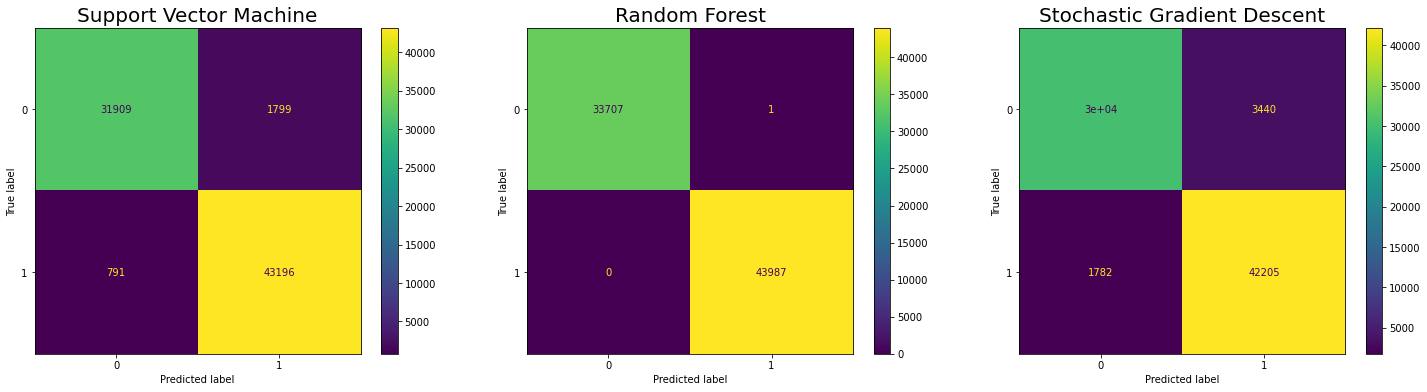

In [40]:
# Draw the confusion matrix:
fig, axs = plt.subplots(1,3, figsize = (25,6))

for i, key in enumerate(training_confusion_matrix_dict.keys()):
    disp = ConfusionMatrixDisplay(confusion_matrix = training_confusion_matrix_dict[key])
    axs[i].set_title(key, fontsize = 20)
    disp.plot(ax=axs[i])


### Different scores
We can compute different metrics on the models:
- Recall
- Precision
- F1 score

In [41]:
training_scores_dict: dict = {k:
{
    "recall": recall_score(target_training, v),
    "precision": precision_score(target_training, v),
    "F1 score": f1_score(target_training, v)
} for k, v in target_training_prediction_dict.items()}


In [42]:
training_scores_dict

{'Support Vector Machine': {'recall': 0.9820174142360243,
  'precision': 0.9600177797533059,
  'F1 score': 0.970892989593401},
 'Random Forest': {'recall': 1.0,
  'precision': 0.9999772665272347,
  'F1 score': 0.9999886331344131},
 'Stochastic Gradient Descent': {'recall': 0.959488030554482,
  'precision': 0.9246357760981487,
  'F1 score': 0.9417395573009639}}

## Assessment on testing set

### Confusion matrix

First use the predict method to return the prediction made on the data_test

In [43]:
target_test_prediction_dict: dict = {k: v.predict(data_test) for k, v in models_dict.items()}

Then for each model draw the confusion matrix

In [44]:
testing_confusion_matrix_dict: dict = {k: confusion_matrix(target_test, v) for k, v in target_test_prediction_dict.items()}

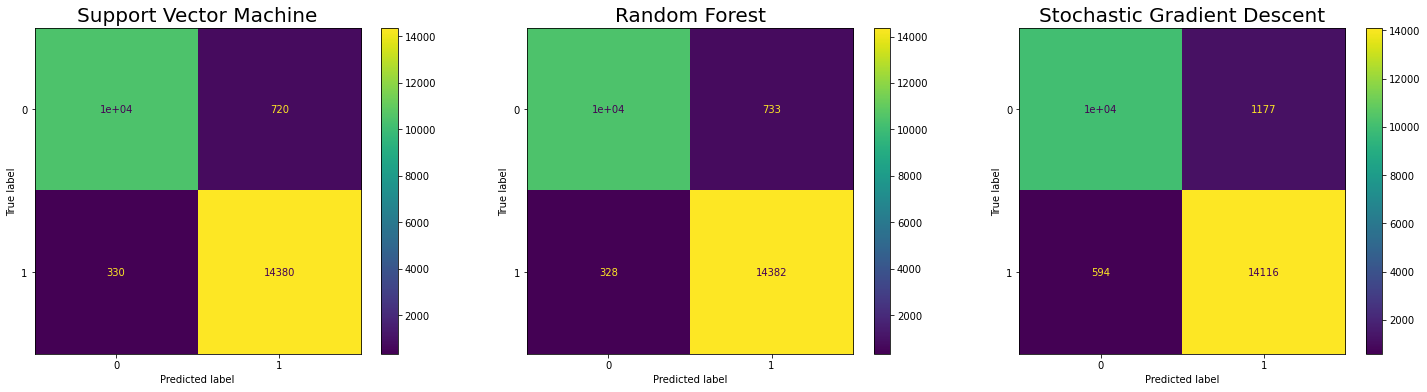

In [45]:
# Draw the confusion matrix:
fig, axs = plt.subplots(1,3, figsize = (25,6))

for i, key in enumerate(testing_confusion_matrix_dict.keys()):
    disp = ConfusionMatrixDisplay(confusion_matrix = testing_confusion_matrix_dict[key])
    axs[i].set_title(key, fontsize = 20)
    disp.plot(ax=axs[i])

### Different scores
We can compute different metrics on the models:
- Recall
- Precision
- F1 score

In [46]:
testing_scores_dict: dict = {k:
{
    "recall": recall_score(target_test, v),
    "precision": precision_score(target_test, v),
    "F1 score": f1_score(target_test, v)
} for k, v in target_test_prediction_dict.items()}


In [47]:
testing_scores_dict

{'Support Vector Machine': {'recall': 0.9775662814411965,
  'precision': 0.952317880794702,
  'F1 score': 0.9647769204964778},
 'Random Forest': {'recall': 0.9777022433718559,
  'precision': 0.9515051273569302,
  'F1 score': 0.9644258172673932},
 'Stochastic Gradient Descent': {'recall': 0.9596193065941536,
  'precision': 0.9230366834499444,
  'F1 score': 0.9409725694097257}}

# Evaluation: Model Comparison and Analysis

## Training dataset result

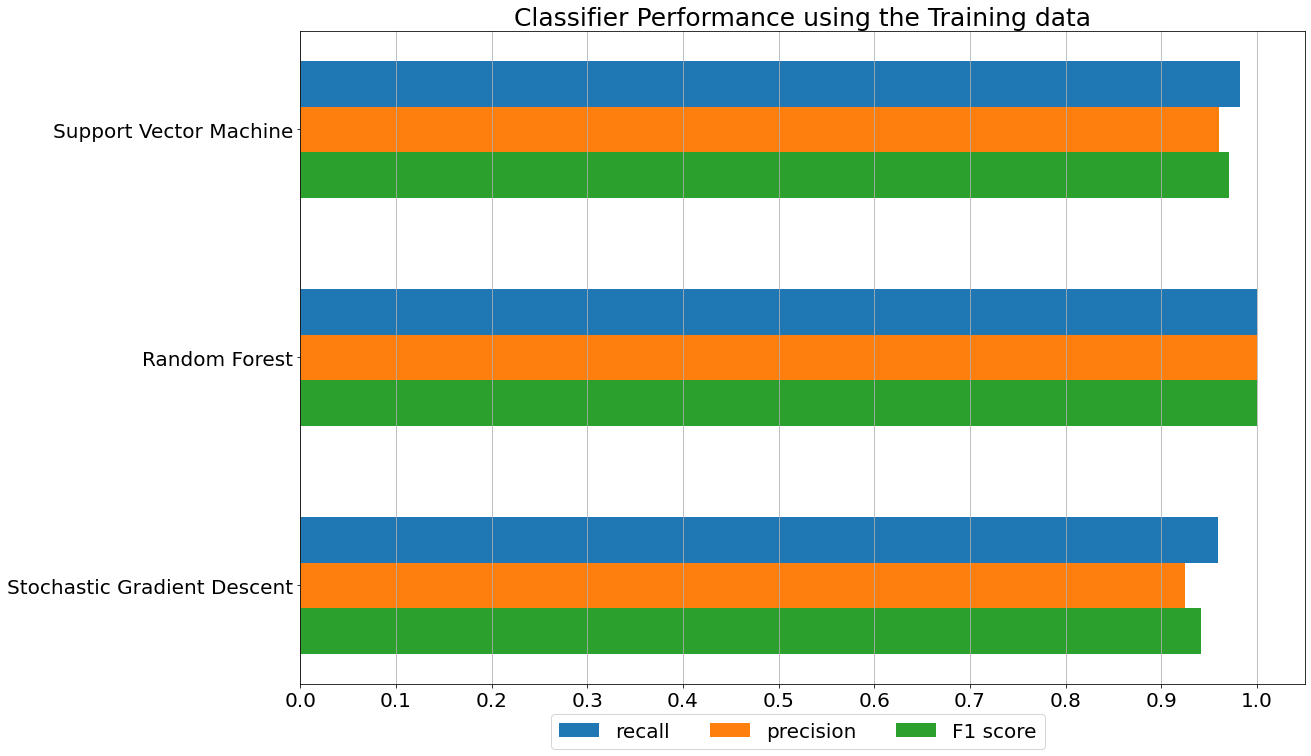

In [48]:
comparaison_plot_function(training_scores_dict, title = "Classifier Performance using the Training data")

## Testing dataset result

In [ ]:
comparaison_plot_function(testing_scores_dict, title = "Classifier Performance using the test data")

## Result explanation
Quick recap on the definition of the scores:
tp = true positive
tn = true negative
fp = false positive
fn = false negative
Precision = tp/(tp + fp)
Recall = tp/(tp + fn)
### Training set analysis
We see in the confusion matrix that:
- The random forest has an almost perfect score on the training set: only 1 error, that is false positive
- The Support Vector Machine (SVC) has good scores, but tends to catch False positive more : 1799 false negative compared to 791. Note that the data is quite balances: 43987 positive and 33708 negative, so that is why even in proportion, the classifier tends to catch false positives
- The Stochastic Gradient Descent (SGD) has the lowest scores, and tends to catch false positives aswell
This is reflected in the recall, precision and f1 score of each solver.
- The random forest has perfect recall, and almost perfect precision and hence f1 score as expected
- The SVC has great precision of 96.6%, and a recall of 98.2%
- The SGD has precision of 92.5% and better recall of 95.9%

### Testing set analysis
As expected, the scores on the testing set are lower than on the training set, because it is a yet-unseen set for the models. The contrary would have been extremely weird. \
We see in the confusion matrix that:
- The 3 models tends to catch false positive more
- Random forest is no longer perfect: it failed on some predictions
- The performance of SVM and random forest are similar
- The SGD, as for the training set, performs worse than the 2 other models
This results are also reflected in the scores for each solver:
- The SGD has worse results for the 3 scores than the random forest and SVM
- The SVM has 97.76% recall, which is worse than the recall score of random forest: 97.77%
- The random forest has 95.15% precision, which is worse than the precision score of the SVM: 95.23%
- Overall, the SVM has a f1 score of 96.5% while the random forest has f1 score of 96.4%

### Choice of the solver
To choose between solvers, first we can see if some solvers are better for all metric than other solvers.\
This allow us to decide that the SGD is uniformly worse than SVM and random forest, so we can already eliminate it. \
Now, the scores between SVM and random forest are very similar, so the choice here becomes quite subjective. \
Personally, I think that a flight company would prefer to be able to predict all of the dissatisfied customer, at the expense of maybe identifying some customer as dissatisfied when \
they are satisfied. In terms of statistics, this means that the company would want to have 0 false negatives. So in term of score, it means a recall close to 1. \
Therefore, I would choose the solver with the higher recall, so the random forest.
